## Course Project: Bolus Glucose Control in Type 1 Diabetes Using Deep Reinforcement Learning
Raphael Joost, 18-???-??? & Yanis Schärer, 18-114-058

### Implementing a Deep Deterministic Policy Gradient (DDPG) agent


In [1]:
import numpy as np
import torch as th
import torch.nn.functional as F
from copy import deepcopy
import gym

In [2]:
# Define Replay Buffer
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, device, max_size=int(1e6)):
        self.device = device
        self.max_size = max_size
        self.size = 0
        self.ptr = 0
        self.state_buffer = np.zeros((max_size, state_dim))
        self.action_buffer = np.zeros((max_size, action_dim))
        self.next_state_buffer = np.zeros((max_size, state_dim))
        self.reward_buffer = np.zeros((max_size, 1))
        self.done_buffer = np.zeros((max_size, 1))

    def store(self, state, action, reward, next_state, done):
        self.state_buffer[self.ptr] = state
        self.action_buffer[self.ptr] = action
        self.next_state_buffer[self.ptr] = next_state
        self.reward_buffer[self.ptr] = reward
        self.done_buffer[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        idx = np.random.randint(0, self.size, size=batch_size)
        return (
            th.tensor(self.state_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.action_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.reward_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.next_state_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.done_buffer[idx], dtype=th.float32).to(self.device)
        )

In [3]:
# Define Actor and Critic networks
class Actor(th.nn.Module): # state -> action
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.l1 = th.nn.Linear(state_dim, 400)
        self.l2 = th.nn.Linear(400, 300)
        self.l3 = th.nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return self.max_action * th.tanh(self.l3(a))

class Critic(th.nn.Module): # state + action -> Q(s,a) (Q-Network)
    def __init__(self, state_dimension, action_dimension):
        super(Critic, self).__init__()
        self.l1 = th.nn.Linear(state_dimension + action_dimension, 400)
        self.l2 = th.nn.Linear(400, 300)
        self.l3 = th.nn.Linear(300, 1)

    def forward(self, state, action):
        q = F.relu(self.l1(th.cat([state, action], 1)))
        q = F.relu(self.l2(q))
        return self.l3(q)

In [4]:
# Define Agents
class DDPGAgent(object):
    def __init__(self, state_dim, action_dim, max_action, device, discount=0.99, tau=0.005):
        self.device = device
        self.discount = discount
        self.tau = tau
        # Actor and Actor target
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_optimizer = th.optim.Adam(self.actor.parameters())
        self.actor_target = deepcopy(self.actor)
        # Critic and Critic target
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_optimizer = th.optim.Adam(self.critic.parameters())
        self.critic_target = deepcopy(self.critic)
        
    def select_action(self, state): # Actor selects action based on current state
        state = th.FloatTensor(state).reshape(1, -1).to(self.device)
        return self.actor(state).cpu().data.numpy().flatten()

    @staticmethod
    def soft_update(local_model, target_model, tau): # Soft update of target parameters
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

    def train(self, replay_buffer, batch_size=100):
        # Sample from replay buffer
        state, action, next_state, reward, done = replay_buffer.sample(batch_size)
        # Compute the target Q value
        target_q = self.critic_target(next_state, self.actor_target(next_state))
        target_q = reward + (done * self.discount * target_q).detach()
        # Get current Q estimate
        current_q = self.critic(state, action)
        # Compute critic loss
        critic_loss = F.mse_loss(current_q, target_q)
        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # Compute actor loss
        actor_loss = -self.critic(state, self.actor(state)).mean()
        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        # Update the target models
        DDPGAgent.soft_update(self.critic, self.critic_target, self.tau)
        DDPGAgent.soft_update(self.actor, self.actor_target, self.tau)

### Linking the DDPG agent to the OpenAI Gym environment

In [5]:
import os
import gym

In [7]:
gym.envs.register(
    id='simglucose-adolescent2-v0',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'adolescent#002'}
)

import gym

# Register gym environment. By specifying kwargs,
# you are able to choose which patient to simulate.
# patient_name must be 'adolescent#001' to 'adolescent#010',
# or 'adult#001' to 'adult#010', or 'child#001' to 'child#010'
from gym.envs.registration import register
register(
    id='simglucose-adolescent2-v0',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'adolescent#002'}
)

env = gym.make('simglucose-adolescent2-v0')

observation = env.reset()
for t in range(100):
    env.render(mode='human')
    print(observation)
    # Action in the gym environment is a scalar
    # representing the basal insulin, which differs from
    # the regular controller action outside the gym
    # environment (a tuple (basal, bolus)).
    # In the perfect situation, the agent should be able
    # to control the glucose only through basal instead
    # of asking patient to take bolus
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t + 1))
        break

In [8]:
env = gym.make('simglucose-adolescent2-v0')

c:\Users\juGin\Anaconda3\envs\RL\lib\site-packages\gym\envs\registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [9]:
state = env.reset()

[30.]
[0.]


c:\Users\juGin\Anaconda3\envs\RL\lib\site-packages\simglucose\simulation\env.py:174: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['CHO'] = pd.Series(self.CHO_hist)
c:\Users\juGin\Anaconda3\envs\RL\lib\site-packages\simglucose\simulation\env.py:175: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['insulin'] = pd.Series(self.insulin_hist)


Observation(CGM=162.44481714861888)
{'sample_time': 3.0, 'patient_name': 'adolescent#002', 'meal': 0.0, 'patient_state': array([    0.        ,     0.        ,     0.        ,   280.48595509,
          32.46917888,    84.99257919,    29.27084371,   133.28696963,
         119.27316864,    24.46363227, 10293.10091346,   293.12046375,
         278.53713393]), 'time': datetime.datetime(2018, 1, 1, 7, 3), 'bg': 151.36584953478192, 'lbgi': 0.0, 'hbgi': 3.0709412699798437, 'risk': 3.0709412699798437}
meal 0.0


KeyError: 'glucose'

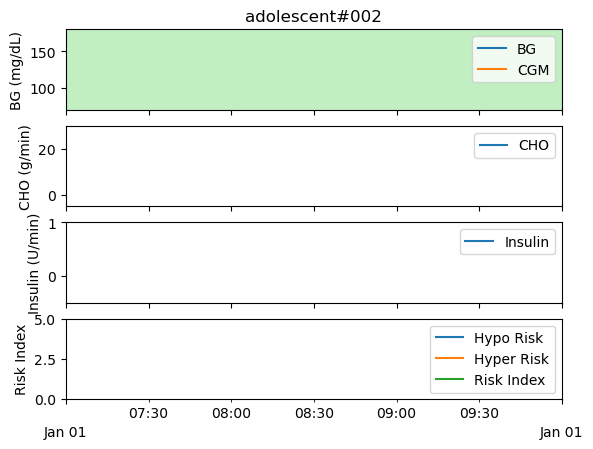

In [16]:
observation = env.reset()
print(env.action_space.high)
print(env.action_space.low)
for t in range(50):
    env.render(mode='human')
    print(observation)
    # Action in the gym environment is a scalar
    # representing the basal insulin, which differs from
    # the regular controller action outside the gym
    # environment (a tuple (basal, bolus)).
    # In the perfect situation, the agent should be able
    # to control the glucose only through basal instead
    # of asking patient to take bolus
    action = 30
    observation, reward, done, info = env.step(action)
    # get the meal information
    meal = info['meal']
    print(info)
    print('meal ' + str(meal))
    # get the glucose information
    glucose = info['glucose']
    print('glucose ' + str(glucose))
    print('reward ' + str(reward))
    if done:
        print("Episode finished after {} timesteps".format(t + 1))
        break

In [ ]:
# Actions are just values between 0 and 30
# In paper action is vector of 3 values
# reward is also different

# Make a wrapper to change reward

class DiscretedReward(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.min_reward = -2
        self.max_reward = 0.5
        self.reward_range = (self.min_reward, self.max_reward)
    
    def reward(self, reward):
        

c:\Users\juGin\Anaconda3\envs\RL\lib\site-packages\gym\envs\registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
c:\Users\juGin\Anaconda3\envs\RL\lib\site-packages\simglucose\simulation\env.py:174: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['CHO'] = pd.Series(self.CHO_hist)
c:\Users\juGin\Anaconda3\envs\RL\lib\site-packages\simglucose\simulation\env.py:175: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['insulin'] = pd.Series(self.insulin_hist)


Observation(CGM=162.66262991263224)
reward 0.5
Reward = 0.5
Observation(CGM=163.07789743655957)
reward 0.5
Reward = 0.5
Observation(CGM=162.65907542702104)
reward 0.5
Reward = 0.5
Observation(CGM=161.521892763117)
reward 0.5
Reward = 0.5
Observation(CGM=159.55034564946425)
reward 0.5
Reward = 0.5
Observation(CGM=156.52419165225783)
reward 0.5
Reward = 0.5
Observation(CGM=152.25295583914698)
reward 0.5
Reward = 0.5
Observation(CGM=146.67618975371593)
reward 0.5
Reward = 0.5
Observation(CGM=139.8739626937518)
reward 0.5
Reward = 0.5
Observation(CGM=131.95816644284233)
reward 0.5
Reward = 0.5
Observation(CGM=122.96634866175415)
reward 0.5
Reward = 0.5
Observation(CGM=112.91222731623864)
reward 0.5
Reward = 0.5
Observation(CGM=101.86248072394002)
reward 0.5
Reward = 0.5
Observation(CGM=90.04673041688692)
reward 0.5
Reward = 0.5
Observation(CGM=77.8231501546183)
reward 0.5
Reward = 0.5
Observation(CGM=65.61654345514887)
reward -1.5
Reward = -1.5
Observation(CGM=53.80713056506216)
reward -1.

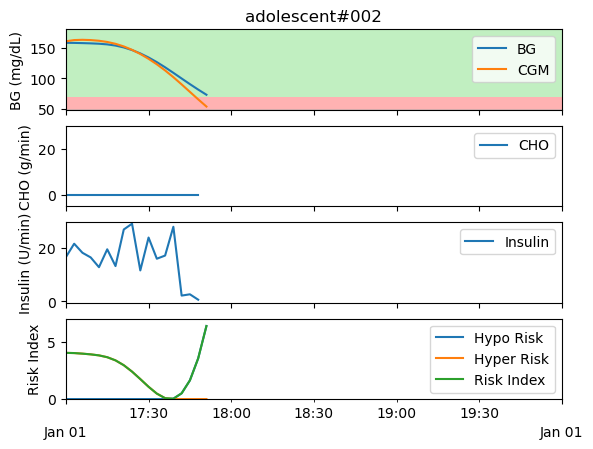

In [5]:
import gym
from gym.envs.registration import register


def custom_reward(BG_last_hour):
    if BG_last_hour[-1] >= 70 and BG_last_hour[-1] <= 180:
        return 0.5
    elif BG_last_hour[-1] > 180 and BG_last_hour[-1] <= 300:
        return -0.8
    elif BG_last_hour[-1] > 300 and BG_last_hour[-1] <= 350:
        return -1
    elif BG_last_hour[-1] >= 30 and BG_last_hour[-1] < 70:
        return -1.5
    else:
        return -2


register(
    id='simglucose-adolescent2-v0',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'adolescent#002',
            'reward_fun': custom_reward}
)


env = gym.make('simglucose-adolescent2-v0')

reward = 1
done = False

observation = env.reset()
for t in range(200):
    env.render(mode='human')
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    print(observation)
    print('reward ' + str(reward))
    print("Reward = {}".format(reward))
    env.get_meal(t)
    if done:
        print("Episode finished after {} timesteps".format(t + 1))
        break

In [ ]:
# --------- Create Custom Scenario --------------
# Create a simulation environment
patient = T1DPatient.withName('adolescent#001')
sensor = CGMSensor.withName('Dexcom', seed=1)
pump = InsulinPump.withName('Insulet')
# custom scenario is a list of tuples (time, meal_size)
scen = [(7, 70), (14, 110), (21, 90)]
scenario = CustomScenario(start_time=start_time, scenario=scen)
env = T1DSimEnv(patient, sensor, pump, scenario)


In [12]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

state_dimension = env.observation_space.shape[0]
action_dimension = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
agent = DDPGAgent(state_dimension, action_dimension, max_action, device)
memory = ReplayBuffer(state_dimension, action_dimension, device)

In [14]:
score_history = []
num_episodes = 1000
for episode in range(num_episodes):
    state = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        memory.store(state, action, next_state, reward, done)
        state = next_state
        score += reward
    score_history.append(score)
    agent.train(memory)
    print(f'Episode: {episode} Score: {score}')

Episode: 0 Score: -23.582171751194014
Episode: 1 Score: -4.754356228833474
Episode: 2 Score: -16.158880647234902
Episode: 3 Score: -5.047603681832058
Episode: 4 Score: -0.19435636738973416
Episode: 5 Score: -4.253971629207639
Episode: 6 Score: -2.540037593980623
Episode: 7 Score: 0.1718842987123208
Episode: 8 Score: -9.80442246600418
Episode: 9 Score: -8.175262554804752
Episode: 10 Score: -6.113026963773256


KeyboardInterrupt: 